In [1]:
!pip install emoji


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install tqdm


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
!pip install nltk



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
!pip install transformers


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
!pip install pyspellchecker


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
!pip install torchtext


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import regex as re
import string
import emoji
import torch

import nltk
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder

from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset, SequentialSampler
from torch.optim import AdamW

from collections import Counter
from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from itertools import chain

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

In [8]:
#from torchtext.data import get_tokenizer

In [9]:
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Basic Information About the Dataset

In [10]:
df.shape

(14640, 15)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Statistical description of numerical columns 

In [12]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## Checking Data Balance

In [13]:
def check_class_balance(df, label_column):
    class_counts = df[label_column].value_counts()
    print("\nBroj primera po klasi:")
    print(class_counts)
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Balansiranost klasa')
    plt.xlabel('Klasa')
    plt.ylabel('Broj primera')
    plt.show()


Broj primera po klasi:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


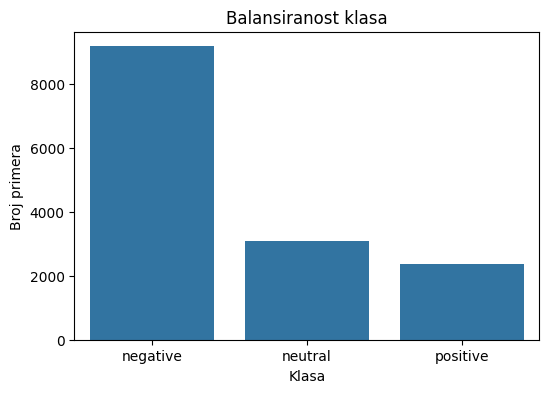

In [14]:
check_class_balance(df, 'airline_sentiment')

## Text length analysis


Basic Statistics on Text Lengths:
count    14640.000000
mean        17.653415
std          6.882259
min          2.000000
25%         12.000000
50%         19.000000
75%         23.000000
max         36.000000
Name: text, dtype: float64


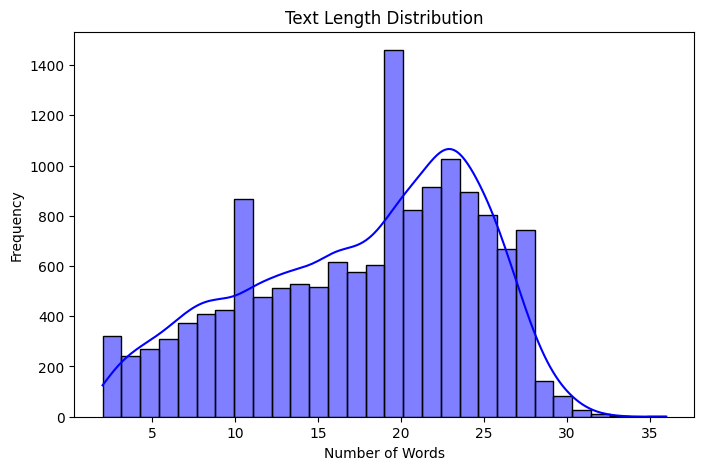

In [15]:
def analyze_text_length(df, text_column):
    text_lengths = df[text_column].apply(lambda x: len(str(x).split()))
    
    print("\nBasic Statistics on Text Lengths:")
    print(text_lengths.describe())
    
    plt.figure(figsize=(8, 5))
    sns.histplot(text_lengths, bins=30, kde=True, color='blue')
    plt.title('Text Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

analyze_text_length(df, 'text')


In [16]:
# Get the target column and show the first few entries
y = df['airline_sentiment']
y.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

In [17]:
X = df["text"].str.lower()
X.head()

0                  @virginamerica what @dhepburn said.
1    @virginamerica plus you've added commercials t...
2    @virginamerica i didn't today... must mean i n...
3    @virginamerica it's really aggressive to blast...
4    @virginamerica and it's a really big bad thing...
Name: text, dtype: object

In [18]:
X[0]

'@virginamerica what @dhepburn said.'

# Preprocessing data



In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Removing HTML tags

In [20]:
def clean_tags(text):
    pattern = r"<[^>]+>"
    cleaned_text = re.sub(pattern, "", text)

    return cleaned_text

df['text'] = df['text'].apply(clean_tags)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Removing urls

In [21]:
def remove_urls(text):
    pattern = r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
    cleaned_text = re.sub(pattern, "", text)

    return cleaned_text

df['text'] = df['text'].apply(remove_urls)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Removing mentions

In [22]:
def clean_at_mentions(text):
    pattern = r"@\S+"
    cleaned_text = re.sub(pattern, "", text)

    return cleaned_text

df['text'] = df['text'].apply(clean_at_mentions)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,What said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you've added commercials to the experien...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,I didn't today... Must mean I need to take an...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"it's really aggressive to blast obnoxious ""en...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Removing extra whitespace

In [23]:
def remove_extra_whitespace(text):
    text = text.strip()
    text = " ".join(text.split())

    return text

df['text'] = df['text'].apply(remove_extra_whitespace)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,What said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you've added commercials to the experienc...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,I didn't today... Must mean I need to take ano...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"it's really aggressive to blast obnoxious ""ent...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Replacing sequences of “a” and “h” with a word “laugh”


In [24]:
def replace_laughs_with_word(text):
    pattern = r"\b([ah]{2,})\b"
    tagged_text = re.sub(pattern, "laugh", text, flags=re.IGNORECASE)

    return tagged_text

df['text'] = df['text'].apply(replace_laughs_with_word)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,What said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you've added commercials to the experienc...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,I didn't today... Must mean I need to take ano...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"it's really aggressive to blast obnoxious ""ent...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Converting emoticons and emojis to text

In [25]:
chat_words_str = {}
with open('emoticons.py', 'r') as file:
    # Izvršite sadržaj fajla u trenutnom kontekstu
  exec(file.read(), globals(), locals())
    # Pretpostavljamo da je rečnik u fajlu dodeljen kao emoticons_dict
  EMOTICONS_EMO = locals().get('EMOTICONS_EMO', {})

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        #text = re.sub('('+emot+')', "_".join(EMOTICONS_EMO[emot].replace(",","").split()), text)
        # Escape special characters in emoticon
        escaped_emot = re.escape(emot)
        # Replace emoticon with its corresponding word
        replacement = "_".join(EMOTICONS_EMO[emot].replace(",", "").split())
        text = re.sub(escaped_emot, replacement, text)
    return text

df['text'] = df['text'].apply(convert_emoticons)
df['text'].head()

0                                           What said.
1    plus you've added commercials to the experienc...
2    I didn't today... Must mean I need to take ano...
3    it's really aggressive to blast obnoxious "ent...
4             and it's a really big bad thing about it
Name: text, dtype: object

In [26]:
def convert_emojis(text):
  converted = emoji.demojize(text)
  converted = ' '.join([word.strip(':') for word in converted.split()])
  return converted

df['text'] = df['text'].apply(convert_emojis)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,What said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you've added commercials to the experienc...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,I didn't today... Must mean I need to take ano...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"it's really aggressive to blast obnoxious ""ent...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Convert slang

In [27]:
def convert_slang(text):
  with open('slang.txt', 'r') as file:
    chat_words_str = file.read()

  chat_words_map_dict = {}
  chat_words_list = []

  for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded

  chat_words_list = set(chat_words_list)

  new_text = []
  for w in text.split():
      if w.upper() in chat_words_list:
          new_text.append(chat_words_map_dict[w.upper()])
      else:
          new_text.append(w)

  return " ".join(new_text)

df['text'] = df['text'].apply(convert_slang)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,What said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you've added commercials to the experienc...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,I didn't today... Must mean I need to take ano...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"it's really aggressive to blast obnoxious ""ent...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Remove punctuation

In [28]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

df['text'] = df['text'].apply(remove_urls)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,What said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you've added commercials to the experienc...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,I didn't today... Must mean I need to take ano...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"it's really aggressive to blast obnoxious ""ent...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Tokenization

In [29]:
from transformers import BertTokenizer

# Load the pre-trained BERT tokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, clean_up_tokenization_spaces=True)

In [30]:
tokens = df['text'].apply(lambda text: tokenizer.tokenize(text))

In [31]:
#token_ids = tokenizer.convert_tokens_to_ids(tokens[0])

### Choosing Sequence Length

In [32]:
token_lens = []

for txt in df['text']:
    # Explicitly apply truncation to ensure tokens are cut off at max_length
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

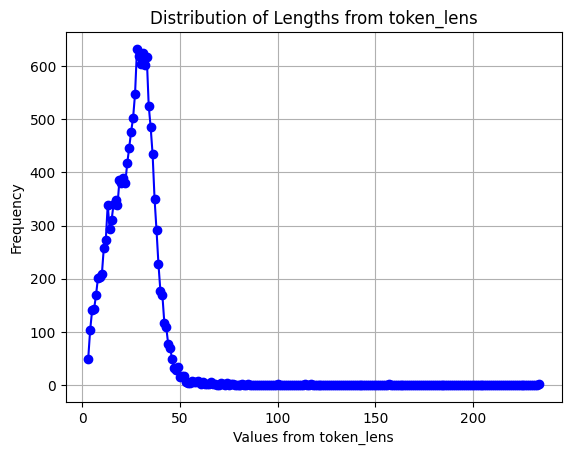

In [33]:
#histogram of the token lengths, showing the distribution of their frequencies.
y, x = np.histogram(token_lens, bins=np.arange(np.min(token_lens), np.max(token_lens) + 1))
plt.plot(x[:-1], y, marker='o', linestyle='-', color='b')
plt.xlabel('Values from token_lens')
plt.ylabel('Frequency')
plt.title('Distribution of Lengths from token_lens')
plt.grid(True)
plt.show()

In [34]:
max(token_lens)

235

In [35]:
MAX_LEN = 256

In [36]:
class TweetSentimentDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    # Initialize the dataset with tweets, targets, tokenizer, and maximum sequence length
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    # Return the number of tweets in the dataset
    return len(self.tweets)

  def __getitem__(self, item):
    # Get the tweet and its target label for the given index
    tweet = str(self.tweets[item])
    target = self.targets[item]

    # Tokenize the tweet with padding and attention mask
    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    # Return the tokenized tweet and the target label
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [37]:
# Set a random seed for reproducibility
RANDOM_SEED=42
# Split the dataset into training and testing sets (5% test size)
df_train, df_test = train_test_split(df, test_size=0.05, random_state=RANDOM_SEED)
# Further split the training set into training and validation sets (5% validation size)
df_train, df_val = train_test_split(df_train, test_size=0.05, random_state=RANDOM_SEED)

In [38]:
df_train.shape, df_val.shape, df_test.shape

((13212, 15), (696, 15), (732, 15))

In [39]:
# Encodes categorical labels into numerical values using LabelEncoder
label_encoder = LabelEncoder()
airline_sentiment = label_encoder.fit_transform(df['airline_sentiment'])
airline_sentiment

array([1, 2, 1, ..., 1, 0, 1])

In [40]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  label_encoder = LabelEncoder()
  airline_sentiment = label_encoder.fit_transform(df['airline_sentiment'])

  # Create a dataset using the TweetSentimentDataset class
  ds = TweetSentimentDataset(
    tweets=df.text.to_numpy(),
    targets= airline_sentiment,
    tokenizer=tokenizer,
    max_len=max_len
  )

  # Return a DataLoader for batching and parallel processing
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [41]:
BATCH_SIZE = 5
# Create data loaders for training, validation and test sets with the specified batch size
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
def plot_training_history(history):
    acc = history.history['train_accy']
    val_acc = history.history['val_acc']

    loss = history.history['train_loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
def generate_classification_report(model, all_preds, all_targets):
    

    target_names = ['negative', 'neutral', 'positive']

    report = classification_report(all_targets, all_preds, target_names=target_names, output_dict=True)

    for target_name in target_names:
        precision = report[target_name]['precision']
        recall = report[target_name]['recall']
        f1_score = report[target_name]['f1-score']

        print(f'{target_name} Precision: {precision:.2f}')
        print(f'{target_name} Recall: {recall:.2f}')
        print(f'{target_name} F1 Score: {f1_score:.2f}')
        print()

    avg_precision = report['weighted avg']['precision']
    avg_recall = report['weighted avg']['recall']
    avg_f1_score = report['weighted avg']['f1-score']

    print('Average Precision: {:.2f}'.format(avg_precision * 100))
    print('Average Recall: {:.2f}'.format(avg_recall * 100))
    print('Average F1 Score: {:.2f}'.format(avg_f1_score * 100))

    return avg_precision, avg_recall, avg_f1_score


In [ ]:
def plot_roc_curve(model, all_preds, all_targets):
    fpr, tpr, _ = roc_curve(all_targets, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(model, all_preds, all_targets):
    confusion = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Sentiment analysis     


In [42]:
BATCH_SIZE = 64
NUMBER_OF_EPOCHS = 10
DROPOUT_PROB = 0.5

In [43]:
class CustomBertModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomBertModel, self).__init__()
        # Load pre-trained BERT model 
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # (batch_size, 768)
        self.dropout = nn.Dropout(p=DROPOUT_PROB) # Dropout layer for regularization
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes) 
        nn.init.xavier_uniform_(self.fc.weight) # Initialize weights of the fully connected layer

    def forward(self, input_ids, attention_mask=None):
        # Forward pass through BERT model
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask)
        output = self.dropout(bert_output[1])
        output = self.fc(output)
        return output

In [44]:
def get_device():
  # Return the GPU device if available, otherwise return the CPU
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def bind_gpu(data):
  # Get the device (GPU or CPU)
  device = get_device()
  if isinstance(data, (list, tuple)):
    return [bind_gpu(data_elem) for data_elem in data]
  else:
    # Move tensor data to the specified device
    return data.to(device, non_blocking=True)

In [45]:
device = get_device()

In [46]:
class_names = ['negative', 'neutral', 'positive']
model = CustomBertModel(num_classes=len(class_names))
bind_gpu(model) # Move the model to the GPU if available 

CustomBertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

# Training

In [47]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * NUMBER_OF_EPOCHS

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
# Initialize a learning rate scheduler with linear decay based on total training steps
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [49]:
loss_fn = nn.CrossEntropyLoss()

In [50]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    # Set the model to evaluation mode
    model = model.eval()

    losses = []
    correct_predictions = 0
    all_preds = []
    all_targets = []
    # Iterate over the data loader
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model outputs and predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Calculate loss and update metrics
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            all_preds = np.array(all_preds)
            all_targets = np.array(all_targets)

    return correct_predictions.double() / n_examples, np.mean(losses), all_preds, all_targets

## Training loop

In [52]:
history = defaultdict(list) # Initialize a dictionary to store training and validation metrics
best_accuracy = 0    # Track the best validation accuracy

device = get_device()

for epoch in range(NUMBER_OF_EPOCHS):
    
  print(f'Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}')
  print('-' * 10)

  # Train for one epoch
  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  # Evaluate on the validation set
  val_acc, val_loss, all_preds, all_targets = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  # Record metrics
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # Save the model if validation accuracy improves
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.8171345009866677 accuracy 0.7274447471995156
Val   loss 0.6675632212377552 accuracy 0.8132183908045977

Epoch 2/10
----------
Train loss 0.6456873497033732 accuracy 0.8268997880714501
Val   loss 0.660702532893213 accuracy 0.82183908045977

Epoch 3/10
----------
Train loss 0.531925780031152 accuracy 0.8724644262791401
Val   loss 0.8122317251878225 accuracy 0.8304597701149425

Epoch 4/10
----------
Train loss 0.4340753086935293 accuracy 0.9059945504087193
Val   loss 0.916409844023292 accuracy 0.8232758620689655

Epoch 5/10
----------
Train loss 0.3457253045666626 accuracy 0.9324099303663336
Val   loss 1.096228231853872 accuracy 0.8275862068965517

Epoch 6/10
----------
Train loss 0.27352707825950257 accuracy 0.9509536784741144
Val   loss 1.0881369394441467 accuracy 0.8189655172413793

Epoch 7/10
----------
Train loss 0.21210426125758733 accuracy 0.964199212836815
Val   loss 1.2603248846500978 accuracy 0.8074712643678161

Epoch 8/10
----------
Train loss

In [ ]:
_ , _, all_preds, all_targets = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

# BERT + NN

In [53]:
class BertModelWithNN(nn.Module):
    def __init__(self, num_classes):
        super(BertModelWithNN, self).__init__()
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # (batch_size, 768)
        self.dropout = nn.Dropout(p=DROPOUT_PROB)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 400) 
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, num_classes)
        # Initialize weights of the fully connected layers
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask=None):
        # Forward pass through BERT model
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask)
        # Forward pass through fully connected layers with ReLU activations
        output = self.dropout(bert_output[1])
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc3(output)
        output = self.relu(output)
        output = self.fc4(output)
        return output

In [54]:
modelNN = BertModelWithNN(num_classes=len(class_names))
bind_gpu(modelNN)

BertModelWithNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

# Training 2

In [55]:
NUMBER_OF_EPOCHS = 66
optimizerNN = AdamW(modelNN.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * NUMBER_OF_EPOCHS

In [56]:
scheduler = get_linear_schedule_with_warmup(
  optimizerNN,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [57]:
loss_fn = nn.CrossEntropyLoss()

# Training loop NN

In [ ]:
historyNN = defaultdict(list)  # Initialize a dictionary to store training and validation metrics for the new model
best_accuracyNN = 0

for epoch in range(NUMBER_OF_EPOCHS):

  print(f'Epoch {epoch + 1}/{NUMBER_OF_EPOCHS}')
  print('-' * 10)

  # Train the model for one epoch
  train_acc, train_loss = train_epoch(modelNN, train_data_loader, loss_fn, optimizerNN, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  # Evaluate the model on the validation set
  val_acc, val_loss, all_preds, all_targets = eval_model(modelNN, val_data_loader, loss_fn, device, len(df_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  # Record metrics
  historyNN['train_acc'].append(train_acc)
  historyNN['train_loss'].append(train_loss)
  historyNN['val_acc'].append(val_acc)
  historyNN['val_loss'].append(val_loss)

  # Save the model if validation accuracy improves
  if val_acc > best_accuracyNN:
    torch.save(modelNN.state_dict(), 'best_model_stateNN.bin')
    best_accuracyNN = val_acc

Epoch 1/66
----------
Train loss 0.7957792418777754 accuracy 0.6971692400847714
Val   loss 0.5772417045797088 accuracy 0.8247126436781609

Epoch 2/66
----------
Train loss 0.5937652139378464 accuracy 0.8365122615803814
Val   loss 0.7505205565448185 accuracy 0.8189655172413793

Epoch 3/66
----------
Train loss 0.48126552674900075 accuracy 0.8902512867090523
Val   loss 0.9156728791679988 accuracy 0.8304597701149425

Epoch 4/66
----------
Train loss 0.37422173285576577 accuracy 0.9273387829246139
Val   loss 1.1704494104242518 accuracy 0.8060344827586207

Epoch 5/66
----------
Train loss 0.30096777650083956 accuracy 0.9467907962458371
Val   loss 1.1762338079605668 accuracy 0.8074712643678161

Epoch 6/66
----------
Train loss 0.2343481225274778 accuracy 0.9606418407508326
Val   loss 1.126749715512103 accuracy 0.8103448275862069

Epoch 7/66
----------
Train loss 0.19209361178904208 accuracy 0.9692703602785346
Val   loss 1.149710780874427 accuracy 0.8175287356321839

Epoch 8/66
----------
Tra

In [ ]:
_ , _, all_predsNN, all_targetsNN = eval_model(modelNN, test_data_loader, loss_fn, device, len(df_test))

# CNN model

In [ ]:
# Download the compressed FastText embeddings file
!wget -O cc.en.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
# Decompress the downloaded file
!gunzip cc.en.300.vec.gz

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')

In [ ]:
def build_vocab(dataset):
  # Tokenize each text in the dataset and convert to lowercase
  tokenized_dataset = [word_tokenize(text.lower()) for text in dataset]

  # Count the frequency of each token
  token_counts = Counter(chain.from_iterable(tokenized_dataset))

  # Create a vocabulary dictionary with reserved tokens
  vocab = {word: idx + 4 for idx, (word, _) in enumerate(token_counts.items())}
  vocab["<unk>"] = 0
  vocab["<pad>"] = 1
  vocab["<sos>"] = 2
  vocab["<eos>"] = 3
  vocab_size = len(vocab)

  # Get the index for the unknown token
  unk_index = vocab.get('<unk>', -1)
    
  input_ids = []
  for tokenized_sent in tokenized_dataset:
    # Pad or truncate sentences to MAX_LEN
    if len(tokenized_sent) < MAX_LEN:
        tokenized_sent += ['<pad>'] * (MAX_LEN - len(tokenized_sent))
    else:
        tokenized_sent = tokenized_sent[:MAX_LEN]
    
    # Convert tokens to their corresponding input_ids
    input_id = [vocab.get(token, unk_index) for token in tokenized_sent]
    input_ids.append(input_id)
    
  return vocab, vocab_size, np.array(input_ids)

In [ ]:
vocab, vocab_size, input_ids = build_vocab(df.text) 

In [ ]:
max_element = np.max(input_ids)
max_element

In [ ]:
def load_pretrained_vectors(word2idx, fname):
    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [ ]:
embeddings = load_pretrained_vectors(vocab, "cc.en.300.vec") # Load pre-trained word embeddings using the vocabulary
embeddings = torch.tensor(embeddings) # Convert the embeddings to a PyTorch tensor

In [ ]:
embed_dim = embeddings.size()[1] # Get the dimension size of embeddings 
kernel_sizes = [2, 3, 4] # List of kernel sizes for convolutional layers
num_filters = [100,100,100] # Number of filters (channels) for each convolutional layer

In [ ]:
class CNN_NLP(nn.Module):
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 kernel_sizes=[2, 3, 4],
                 num_filters=[100, 100, 100],
                 num_classes=3,
                 dropout=0.25):

        super(CNN_NLP, self).__init__()

        # Initialize embedding layer with pre-trained weights
        self.vocab_size, self.embed_dim = pretrained_embedding.shape
        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=freeze_embedding)

        # (batch_size, seq_len, embedding_dim)
        # Define convolutional layers with varying kernel sizes
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim, 
                      out_channels=num_filters[i],
                      kernel_size=kernel_sizes[i])
            for i in range(len(kernel_sizes))
        ])
        
        # Fully-connected layer and Dropout
        self.fc1 = nn.Linear(np.sum(num_filters), 23808)
        self.fc2 = nn.Linear(23808, num_classes)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        # Get embeddings from input_ids
        x_embed = self.embedding(input_ids).float() #(batch_size, seq_len, embedding_dim)

        # Permute x_embed to match input shape requirement of nn.Conv1d
        x_reshaped = x_embed.permute(0, 2, 1)   #(batch_size, embedding_dim, seq_len)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [self.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [nn.functional.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        #x_fc1 = self.relu(self.fc(x_fc))
        x_fc1 = self.fc1(x_fc)
        x_fc1 = self.dropout(x_fc1)
        #x_fc1 = self.relu(x_fc1)

        logits = self.fc2(x_fc1)

        return logits

In [ ]:
cnn_model = CNN_NLP(pretrained_embedding=embeddings,
                    freeze_embedding=False,
                    vocab_size=vocab_size,
                    embed_dim=embed_dim,
                    kernel_sizes=kernel_sizes,
                    num_filters=num_filters,
                    num_classes=3,
                    dropout=0.25)

In [ ]:
train_data_loaderCNN = create_data_loader(df_train, word_tokenize, MAX_LEN, BATCH_SIZE)

In [ ]:
bind_gpu(cnn_model)
# device = get_device()
# cnn_model.to(device)

In [ ]:
#optimizerCNN = Adam(cnn_model.parameters(), lr=1e-6, correct_bias=False)
optimizerCNN = torch.optim.Adadelta(cnn_model.parameters(),
                               lr=0.01,
                               rho=0.95)
total_steps = len(train_data_loader) * NUMBER_OF_EPOCHS

In [ ]:
scheduler = get_linear_schedule_with_warmup(
  optimizerCNN,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
device = get_device()

In [ ]:
def train_epoch_CNN(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for  input_ids, targets in data_loader:
    input_ids = input_ids.to(device)
    targets = targets.to(device)

    outputs = model(input_ids=input_ids)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#testing
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
def data_loaderCNN(train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels, batch_size=50):
    train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels = tuple(torch.tensor(data) for data in [train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels])
    batch_size = BATCH_SIZE

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    # Create DataLoader for test data
    test_data = TensorDataset(test_inputs, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df.airline_sentiment)
len(labels)

In [ ]:
train_val_inputs, test_inputs, train_val_labels, test_labels = train_test_split(input_ids, labels, test_size=0.05, random_state=42)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_val_inputs, train_val_labels, test_size=0.05, random_state=42)

In [ ]:
train_dataloader, val_dataloader, test_dataloader = data_loaderCNN(train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels, batch_size=50)

In [ ]:
def eval_modelCNN(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad(): # Disable gradient calculations for inference
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(input_ids=inputs)
      # Get predictions
      _, preds = torch.max(outputs, dim=1)
      # Compute loss
      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

      all_preds.extend(preds.cpu().numpy())
      all_targets.extend(targets.cpu().numpy())

      all_preds = np.array(all_preds)
      all_targets = np.array(all_targets)
        
  # Return accuracy and average loss
  return correct_predictions.double() / n_examples, np.mean(losses), all_preds, all_targets

In [ ]:
historyCNN = defaultdict(list)
best_accuracyCNN = 0
NUMBER_OF_EPOCHS_CNN = 66

for epoch in range(NUMBER_OF_EPOCHS_CNN):

  print(f'Epoch {epoch + 1}/{NUMBER_OF_EPOCHS_CNN}')
  print('-' * 10)

  train_acc, train_loss = train_epoch_CNN(cnn_model, train_dataloader, loss_fn, optimizerCNN, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_modelCNN(cnn_model, val_dataloader, loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  historyCNN['train_acc'].append(train_acc)
  historyCNN['train_loss'].append(train_loss)
  historyCNN['val_acc'].append(val_acc)
  historyCNN['val_loss'].append(val_loss)

  if val_acc > best_accuracyCNN:
    torch.save(cnn_model.state_dict(), 'best_model_stateCNN.bin')
    best_accuracyCNN = val_acc

In [ ]:
torch.save(model.state_dict(), 'cnn_model_state_dict.pth')

In [ ]:
torch.save(model, 'cnn_full_model.pth')

In [ ]:
eval_modelCNN(modelCNN, test_dataloader, loss_fn, device, len(test_inputs))

In [ ]:
plot_training_history(historyCNN)